## Introduction

This notebook follows this blog post https://domino.ai/blog/fitting-gaussian-process-models-python. 
<br>
The variable names etc. are set according to the online lecture of Conrell University https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote15.html 
- FYI the lecture is great but as stated in Source slide of PP: 
	- The Multivariate gaussian distribution is written here with the normalization factor $\propto\det\left( \Sigma \right)$ while it should be $\propto\det\left( \Sigma \right)^{-1/2}$
	- In notation of conditional normal distribution the formular for the covariance Matrix is wrong, K and K_** are switched
<br> and https://distill.pub/2019/visual-exploration-gaussian-processes/ 

Kernels in first source are taken from https://www.cs.toronto.edu/~duvenaud/cookbook/ which gives more kernels and describes the parameters a little different

In [ ]:
# ---------- Import packages ---------- #
import numpy as np
import matplotlib.pylab as plt

# Alternative colormaps, used here for the covarianc matrix plots
from palettable.cmocean.sequential import Tempo_20_r 
palettable_cmap = Tempo_20_r
pal_cmap = palettable_cmap.mpl_colormap


# Multivariate Gaussian 
A multivariate gaussian distribution/ normal distribution is defined as
$$ \mathcal{N}(x,\mu,\Sigma) = \frac{1}{\left[(2 * \pi)^d * det(\Sigma)\right]^{1/2}} * \exp{\left(-\frac{1}{2} (x-\mu)^T \Sigma^{-1} (x-\mu) \right)}$$
where $\mu$ is the vecotor of mean values, $\Sigma$ is the covariance matrix containing the variances on the diagonal (diag($\Sigma$) = $\sigma^2$ with $\sigma^2$ the standard deviation) and the "correlations" on the offdiagonals, $d$ is the dimension of $\mu$  

# Conditional Gaussian distribution

The distribution of all possible functions p(W|D) is also a Gaussian distribution with covariance matrix 
$$ 
\Sigma = 
  \begin{bmatrix}
    K & K_* \\
    K_*^T & K_{**}
  \end{bmatrix} 
  = 
  \begin{bmatrix}
    k(x_0,x_0)      & k(x_0,x_1)        & \cdots  & k(x_0,x_{n})      & k(x_0,x_{test}) \\
    k(x_1,x_0)      & k(x_1,x_1)        &         &                   & k(x_1,x_{test}) \\
    \vdots          &                   & \ddots  &                   & \vdots \\
    k(x_n,x_0)      & k(x_n,x_1)        &         & \ddots            & k(x_{n},x_{test}) \\ 
    k(x_{test},x_0) & k(x_{test},x_1)   & \cdots  &  k(x_{test},x_{n}) & k(x_{test},x_{test}) \\


  \end{bmatrix} 
  
  $$

where 
- $K$ is the training kernel matrix (created from training data)
  - $K = kernel(x_{train},x_{train})$
<br>
- $K_*$ is the training-testing matrix
  - $K_* = kernel(x_{train},x_{test})$
<br>
- $K_*^T$ is the testing- training matrix
<br>
- $K_{**}$ is the testing kernel Matrix (created with test data)
  - $K_{**} = kernel(x_{test},x_{test})$

therefore the gaussian distribution becomes
$$ \mathcal{N}(\mu,\Sigma) = N(K_*^TK_{**}^{-1}y, \quad K - K_*^T K_{**}^{-1} K_*)$$ 
where the covariances are calculated with a kernel function



# Used kernels 
### RBF kernel
$$ k(x_1,x_2) = \theta_1^2 * \exp{\left( -\frac{(x_1 - x_2)^2}{2 \theta_2^2}  \right)} $$
- $\theta_1 =$ $\sigma$ scale factor<br>
- $\theta_2 =$ l length scale parameter



### Periodic kernel
$$ k(x_1,x_2) = \theta_1^2 * \exp\left[ - 2 * { \sin^2 \left( \frac{\pi  |x_1-x_2|}{\theta_2}  \right)} / {\theta_3}^2 \right] $$
- $\theta_1 =$ $\sigma$ scale factor<br>
- $\theta_2 =$ l length scale parameter
- $\theta_3 =$ p distance between repetitions


### Linear kernel
$$ k(x_1,x_2) = \theta_1^2  + \theta_2^2 (x_1 - \theta_3) ( x_2- \theta_3) $$

- $\theta_1 =$ $\sigma$ scale factor<br>
- $\theta_2 =$ c offset without noise 𝜎=0 
- $\theta_3 =$ $\sigma_𝑏^2$ how far from c $\sigma$=0


In [ ]:
# ---------- Define all the kernel functions ---------- # 

def RBF_kernel(x1, x2, parameters):
	'''' 
		x1/ x2 the 1D arrays of which the covarianc matrix is created\n
		parameters - 2 input parameters in an array for amplitute (here ~ 1 sigma range of prediction = theta 1, and theta 2 some scaling factor)
	'''
	theta1 = parameters[0] # ~ standard deviation since in return of function the Variance (square of std) is calculated
	theta2 = parameters[1] # length scale parameter

	# RBF kernel creation for all elements at once
	return theta1**2 * np.exp(- 1/(2 * theta2**2) * np.subtract.outer(x1,x2)**2) #if x1 and x2 are 1D objects the kernel will be a 2d Matrix


def periodic_kernel(x1,x2,parameters):
	'''' 
		x1, x2 the 1D arrays of which the covarianc matrix is created
		paramerts- 3 input parameters 
	'''

	pi = np.pi 

	theta_1 = parameters[0] # ~ standard deviation 
	theta_2 = parameters[1] # period 
	theta_3 = parameters[2] # lengthscale

	return theta_1**2 * np.exp( - 2 * np.sin( pi * np.abs(np.subtract.outer(x1,x2)) / theta_2  )**2 / theta_3**2 )


def linear_kernel(x1,x2,parameters):
	'''' 
		x1, x2 the 1D arrays of which the covarianc matrix is created
		paramerts- 3 input parameters theta_2 ~ average distance from function mean, theta_1 = certainty around offset, theta_2 = offset
	'''

	theta_1 = parameters[0] # avg distance from theta3
	theta_2 = parameters[1] # ~ standard deviation 
	theta_3 = parameters[2] # offset

	return theta_1**2 + theta_2**2 *np.multiply.outer((x1 - theta_3),(x2-theta_3))

#### First use a zero mean function to test and plot $1\sigma$ of the RBF kernel with some arbitrary initial parameters for x1 and x2 = 0 

In [ ]:
# create Training data with zero mean (just the x axis)
x_axis = np.linspace(-5,5,100)

# use some arbitrary parameters for RBF kernel
init_params = [1, 2] # sigma | lenghtscale  

# ---------- Create the vector of mean values and the Covaraince matrix ---------- #
mean_1 = np.zeros(len(x_axis)) # just 0 mean (y values in plot)
cov_1 = RBF_kernel(x_axis, x_axis, init_params) # calculate the covariance matrix with the RBF kernel 

# ---------- Plot the Prior distribution ---------- #
# Plot the zero mean over the x_axis
plt.plot(x_axis, mean_1, color = 'black')
# plot the Variance (diagonal of the Covariance matrix)
prior_std = np.sqrt(np.diagonal(cov_1))
plt.fill_between(x_axis, mean_1 - prior_std , mean_1 + prior_std, color = 'gray', alpha = 0.5)

# Draw 5 samples from the Gaussian distiribution with zero mean and covarianc matrix calcualted by RBF kernel
prior_samples = np.random.multivariate_normal(mean_1, cov_1, size=5) 
# plot the drawn samples
plt.plot(x_axis, prior_samples.T, alpha = 0.5)
plt.title('Prior distribution for RBF kernel')
plt.show()

In [ ]:
def plot_cov_Mat(init_params_RBF, init_params_lin, init_params_per):
	''' 
	Function to plot RBF, periodic and linear kernel matrices side by side, outsourced to a \
		function to easily change values during presentation without the need to scroll through to much plotting routine \n
	init_params_RBF - Intial parameters for the RBF kernel\n
	init_params_lin - Intial parameters for the linear kernel\n
	init_params_per - Intial parameters for the periodic kernel\n
	'''


	fig, axs = plt.subplots(1, 3, figsize=(16,4))

	# create x axis 
	x_axis = np.linspace(-10,10,50)

	# ---------------------------------------- RBF Kernel ---------------------------------------- #

	axs[0].imshow(RBF_kernel(x_axis,x_axis,init_params_RBF), cmap=pal_cmap)
	axs[0].set_title('RBF kernel cov. matrix')
	axs[0].set_xticks([])
	axs[0].set_yticks([])

	# -------------------------------------- Periodic Kernel ---------------------------------------- #

	axs[1].imshow(periodic_kernel(x_axis,x_axis,init_params_per), cmap=pal_cmap)
	axs[1].set_title('Periodic kernel cov. matrix')
	axs[1].set_xticks([])
	axs[1].set_yticks([])

	# ---------------------------------------- Linear Kernel ---------------------------------------- #

	axs[2].imshow(linear_kernel(x_axis,x_axis,init_params_lin), cmap=pal_cmap, norm='symlog') 
	# plot here with symlog scale since without this scaling no changes in the distros would be observable through internal normalization to colormap
	axs[2].set_title('Linear kernel cov. matrix')
	axs[2].set_xticks([])
	axs[2].set_yticks([])

	plt.tight_layout()
	plt.show()
	return

In [ ]:
init_params_RBF = [1, 2] 		# sigma | lenghtscale  						# PP uses [1,2]
init_params_per = [1, 8, 0.7] 	# sigma | period | lenghtscale				# PP uses [1,8,0.7]  
init_params_lin = [1, 0.5, 3]	# avg distance from theta3 | sigma | offset	# PP uses [1,0.5,3] as well as [0,1,3] and [4,1,3]

plot_cov_Mat(init_params_RBF, init_params_lin, init_params_per)

#### now start sampling test points (pairs of  x,y), since this is a test to show how gaussian processes work, both values are just arbitrary, in the original blog post the values are taken from a gaussian distribution - here fromblog post to check what is going on


In [ ]:
def predict_value(x_test, y_test, x_train, kernel, kernel_parameters, noise):
	'''
	Function to create the prior distriubtion for a given kernel, kernel parameters (hyperparameters), 
	returns mean values and the covariance matrix and the standard deviations for each mean value \n
	x_test - x value of test point, e.g. \n
	y_test - y value of test point, e.g. measurement value \n
	x_train - Training data e.g. for Linear regressen the x axis \n
	kernel - kernel function to use \n
	kernel_parameters hyperparameters of the kernel function \n
	noise - sigma of the test points (e.g. measurement error) \n
	
	''' 

	identity = np.identity(len(x_test)) # Identity matrix in size of test data for possible noise

	# ---------- Calculate each Submatrix individually ---------- #

	K = kernel(x_train,x_train,kernel_parameters) 							# in PP K_XX
	K_x = kernel(x_train,x_test,kernel_parameters) 							# in PP K_XY
	K_xx = kernel(x_test, x_test, kernel_parameters) + identity.dot(noise**2) 	# in PP K_YY 
	# K_xx - testing Matrix with noise added -> If noise is 0 it just does not add anything 
	# (x means here * according to notation of Cornell University)

	# ---------- Calculate the new mean of the conditional probability ---------- # 
	mu = (K_x).dot(np.linalg.inv(K_xx)).dot(y_test) 
	sigma = K - ( K_x.dot( np.linalg.inv(K_xx) ).dot(K_x.T)) 

	std = np.sqrt(np.diag(sigma)) # calc the standard deviations

	return mu, sigma, std

In [ ]:
def GP(x_axis, init_params, kernel_fct, x_test, y_test, y_test_err):
	''' 
	Function to calculate the Prior distribution, implement the Bayesian interference 
	(update the Prior distribution as soon as test data is introduced)/ calculate the Posterior distribution,
	and plot the Priordistribution with drawn samples and Covariance matrix and do the same for the Posteriro 
	distribution in a side by side plot \n
	
	x_axis - Training data with zero mean (here just the x axis) \n
	init_params - intial parameters for the choosen kernel \n
	kernel_fct - the kernel function \n
	x_test - test point x values \n
	y_test - test point y values \n
	y_test_err - standard deviation of the test values (sigma) \n
	'''

	# ---------- Prepare a big figure that contains Prior and Posterior ---------- ##

	fig, axs = plt.subplots(3, 2, figsize=(9,5)) # 3 wide for last one #16,9


	# Create zero mean values along x axis and create covaraince matrix for prior distribution
	# ---------- Create mu (= 0 training data), Covarianc matrix from training data, and introduce the variances of the ---------- #
	prior_mu = np.zeros(len(x_axis)) # zero mean for prior
	prior_cov = kernel_fct(x_axis, x_axis, init_params) # covariance matrix before introducing test points / measurements
	pior_error = np.sqrt(np.diagonal(prior_cov)) # all the standard deviation values of the prior distribution

	# ---------- Plot the prior interval without samples drawn ---------- # 
	axs[0,0].plot(x_axis, prior_mu, color = 'black')
	axs[0,0].fill_between(x_axis, prior_mu - pior_error, prior_mu + pior_error, \
					   color = 'gray', alpha=0.5, label = r'1 $\sigma$')

	# ---------- Draw samples from prior distro and plot them ---------- #
	prior_samples = np.random.multivariate_normal(prior_mu, prior_cov, size=5).T # draw samples form the GP

	axs[1,0].plot(x_axis, prior_samples, alpha = 0.5 )
	axs[1,0].plot(x_axis, prior_mu, color = 'black')
	axs[1,0].fill_between(x_axis, prior_mu - pior_error, prior_mu + pior_error, \
					   color = 'gray', alpha=0.5, label = r'1 $\sigma$')


	# ---------- Plot the covaraince matrix ---------- #
	# differentiate between linear and other kernels because of normalizing in the matrix plot
	if kernel_fct == linear_kernel:
		norm='symlog'
		axs[2,0].imshow(prior_cov, cmap=pal_cmap, norm='symlog')
	else: 
		axs[2,0].imshow(prior_cov, cmap=pal_cmap)

	axs[2,0].set_xticks([])
	axs[2,0].set_yticks([])

	# ---------- Make the plot nice ---------- #
	axs[0,0].set_title('Prior distrbution')



	# -------------------------------------------------- Introduce test data now -------------------------------------------------- #


	# ---------- Calculate the mean vector and covariance matrix of the conditional gaussian distro with added test data ---------- #
	y_predictions, sigma_predictions, errors_predictions = \
		  predict_value(x_test, y_test, x_axis, kernel_fct, init_params, y_test_err)

	# ---------- Plot the new data ---------- #
	axs[0,1].plot(x_axis, y_predictions, color = 'black')
	axs[0,1].errorbar(x_test, y_test, marker='.', yerr = y_test_err, \
				   ls = 'none', color = 'red', ms = 8, capsize=3)
	
	axs[0,1].fill_between(x_axis, y_predictions - errors_predictions, \
					   y_predictions + errors_predictions, color = 'gray', \
						  alpha = 0.5, label = r'1 $\sigma$')


	# ---------- Draw sample form Posteriror distro ---------- #
	posterior_samples = np.random.multivariate_normal(y_predictions, \
												   sigma_predictions, size=5).T # draw samples form the GP
	
	# ---------- Plot the samples drawn from posterior distro ---------- #
	axs[1,1].plot(x_axis, posterior_samples, alpha = 0.5 )
	axs[1,1].plot(x_axis, y_predictions, color = 'black')
	axs[1,1].errorbar(x_test, y_test, marker='.', yerr = y_test_err, \
				   ls='none', color = 'red', ms = 8, capsize=3)
	
	axs[1,1].fill_between(x_axis, y_predictions - errors_predictions, \
					   y_predictions + errors_predictions, color = 'gray', \
						alpha=0.5, label = r'1 $\sigma$')


	# ---------- Plot the covariance matrix ---------- #
	# differentiate between linear and other kernels because of normalizing in the matrix plot
	if kernel_fct == linear_kernel:
		norm='symlog'
		axs[2,1].imshow(sigma_predictions, cmap=pal_cmap, norm='symlog')
	else: 
		axs[2,1].imshow(sigma_predictions, cmap=pal_cmap)

	axs[2,1].set_xticks([])
	axs[2,1].set_yticks([])

	# ---------- Make the plot nice ---------- #
	axs[0,1].set_title('Posterior distrbution')

	plt.tight_layout()
	plt.show()
	return y_predictions, sigma_predictions, errors_predictions, posterior_samples, prior_samples#, fig, axs

## GP with RBF Kernel 

In [ ]:
# Training Data - zero mean for all following processes
x_axis = np.linspace(-5, 5, 500)

# ---------- Kernel parameters ---------- #
init_params_RBF = [1, 1] # sigma | lenghtscale

# ---------- Test Data ---------- #
x_test = np.array([-1.0, +0.4, 1.0])
y_test = np.array([-0.6, -0.6, 0.4])
y_test_err = np.ones(len(y_test))*0.4

pred_mu, pred_cov_mat, pred_std, posterior_samples, prior_samples = GP(x_axis,init_params_RBF,RBF_kernel,x_test,y_test,y_test_err)

## GP with Linear Kernel 

In [ ]:
# Training Data - zero mean for all following processes
x_axis = np.linspace(-5, 5, 1000)

# ---------- Kernel parameters ---------- #
# define new initial parameters and test points
init_params_lin = [1, 0.5, 3] #[0.2, 1e-2, 1] # avg distance from theta3 | sigma | offset

# ---------- Test Data ---------- #
x_test = np.array([-2.0, +0.0])#, +1.0])
y_test = np.array([-2.0, -1.0])#, -0.4])
y_test_err = np.ones(len(y_test))*0.4

pred_mu, pred_cov_mat, pred_std, posterior_samples, prior_samples = GP(x_axis,init_params_lin,linear_kernel,x_test,y_test,y_test_err)

## GP with Periodic Kernel 

In [ ]:
# Training Data - zero mean for all following processes
x_axis = np.linspace(-5, 5, 1000)

# ---------- Kernel parameters ---------- #
init_params_per = [1,4,2] # sigma | period | lenghtscale # Period = 8 works also (Niyquist theorem)

# ---------- Test Data ---------- #
x_test = np.array([-1,0,1])
y_test = np.array([-0.2,0.8,0.1])
y_test_err = np.ones(len(y_test))*0.4

pred_mu, pred_cov_mat, pred_std, posterior_samples, prior_samples = GP(x_axis,init_params_per,periodic_kernel,x_test,y_test,y_test_err)

## Python packages implementing GP 
Packages and information taken from https://domino.ai/blog/fitting-gaussian-process-models-python

scikit-learn https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-processes:
- allows prediction without prior fitting (based on the GP prior)
- provides an additional method sample_y(X), which evaluates samples drawn from the GPR (prior or posterior) at given inputs
- exposes a method log_marginal_likelihood(theta), which can be used externally for other ways of selecting hyperparameters, e.g., via Markov chain Monte Carlo.
- Can be used for probabilistic classification 

GPflow https://github.com/GPflow/GPflow
- re-implementation of the GPy http://sheffieldml.github.io/GPy/ library using TensorFlow 

PyMC3
- very general Python package for probabilistic programming
- Author of https://domino.ai/blog/fitting-gaussian-process-models-python developer of package
- Build on Theano

Package found in lectrue material of Cornell University https://www.cs.cornell.edu/courses/cs4780/2018fa
GPyTorch https://gpytorch.ai/
- A highly efficient and modular implementation of GPs, with GPU acceleration
- Implemented in PyTorch

## Test of scikit-leanr on data used above

Method taken from basic introductory example given by sciki-learn homepage
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py

scikit-learn defines RBF kernel as following:
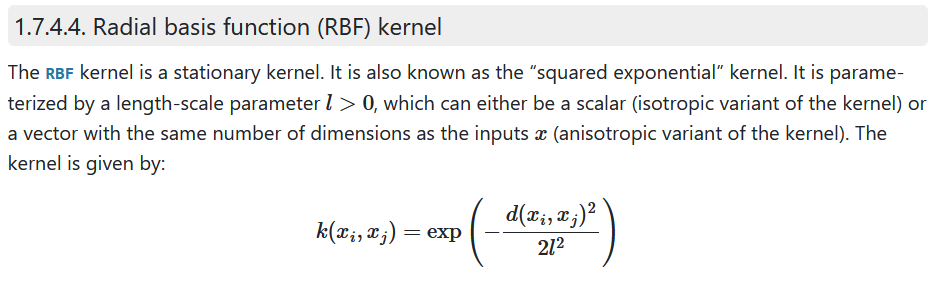
therefore the scaling parameter $\sigma$ has to be put in front by hand 

## GP with RBF Kernel 

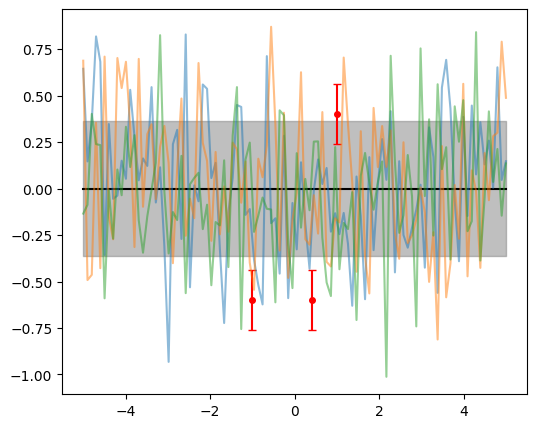

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

x_axis = np.linspace(-5, 5, 100)

init_params_RBF = [1, 1] # sigma | lenghtscale

x_test = np.array([-1.0, +0.4, 1.0])
y_test = np.array([-0.6, -0.6, 0.4])
y_test_err = np.ones(len(y_test))*(0.4**2)
	# could use here also just one value that which is taken for all data points


RBF_kernel_scikit = init_params_RBF[0]**2 * RBF(length_scale=init_params_RBF[1], length_scale_bounds=(1e-10, 1e5))
gaussian_process = GaussianProcessRegressor(kernel = RBF_kernel_scikit, alpha = y_test_err, n_restarts_optimizer = 9)

gaussian_process.fit(x_test.reshape(-1, 1), y_test) # reshape of xaxis need for some reason?
mean_prediction, std_prediction = gaussian_process.predict(x_axis.reshape(-1, 1), return_std=True)


sampled_values = gaussian_process.sample_y(x_axis.reshape(-1, 1), n_samples=3)



fig, ax = plt.subplots(figsize=(6,5))

# ---------- Plot the new data ---------- #
ax.errorbar(x_test, y_test, marker='.', yerr = y_test_err, \
				   ls = 'none', color = 'red', ms = 8, capsize=3)


ax.plot(x_axis, mean_prediction, color = 'black')
ax.fill_between(x_axis, mean_prediction - std_prediction, \
					   mean_prediction + std_prediction, color = 'gray', \
						  alpha = 0.5, label = r'1 $\sigma$')

ax.plot(x_axis, sampled_values, alpha = 0.5 )




# #---------- Alternative Cells ---------- # #

In [ ]:
# fig, axs = plt.subplots(3, 2, figsize=(16,9)) # 3 wide for last one


# # Training Data - zero mean for all following processes
# x_axis = np.linspace(-5, 5, 1000)


# init_params_RBF = [1,2] # taken from blog post

# # Test Data 
# x_test = np.array([1,-3,0.4])
# y_test = np.array([0.4,0.3,-0.6])
# y_test_err = np.ones(len(y_test))*0.2


# # Create zero mean values along x axis and create covaraince matrix for prior distribution

# prior_mu = np.zeros(len(x_axis)) # zero mean for prior
# prior_cov = RBF_kernel(x_axis, x_axis, init_params_RBF) # covariance matrix before introducing test points / measurements
# pior_error = np.diagonal(prior_cov) # all the std values of the prior distribution

# # Plot the prior interval without samples drawn
# axs[0,0].plot(x_axis, prior_mu, color = 'black')
# axs[0,0].fill_between(x_axis, prior_mu - pior_error, prior_mu + pior_error, color = 'gray', alpha=0.5, label = r'1 $\sigma$')

# # Draw samples and plot them
# prior_samples = np.random.multivariate_normal(prior_mu, prior_cov, size=5).T # draw samples form the GP
# axs[1,0].plot(x_axis, prior_samples, alpha = 0.5 )
# axs[1,0].plot(x_axis, prior_mu, color = 'black')
# axs[1,0].fill_between(x_axis, prior_mu - pior_error, prior_mu + pior_error, color = 'gray', alpha=0.5, label = r'1 $\sigma$')


# # plot the covaraince matrix
# axs[2,0].imshow(RBF_kernel(x_axis, x_axis, init_params_RBF), cmap = pal_cmap)

# axs[0,0].set_title('Prior distrbution')



# # -------------------------------------------------- Introduce test data now -------------------------------------------------- #

# # calculate predicted values with the conditional gaussian distribution
# y_predictions, sigma_predictions, errors_predictions = predict_value(x_test, y_test, x_axis, RBF_kernel, init_params_RBF, y_test_err )

# axs[0,1].plot(x_axis,y_predictions, color = 'black')
# axs[0,1].errorbar(x_test, y_test, marker='.', yerr=y_test_err,ls='none', color = 'red', ms = 8, capsize=3)
# axs[0,1].fill_between(x_axis, y_predictions - errors_predictions, y_predictions + errors_predictions, color = 'gray', alpha=0.5, label = r'1 $\sigma$')


# # Get Posteriror samples 
# posterior_samples = np.random.multivariate_normal(y_predictions, sigma_predictions, size=5).T # draw samples form the GP
# axs[1,1].plot(x_axis, posterior_samples, alpha = 0.5 )

# axs[1,1].plot(x_axis, y_predictions, color = 'black')
# axs[1,1].errorbar(x_test, y_test,marker='.', yerr = y_test_err, ls='none', color = 'red', ms = 8, capsize=3)
# axs[1,1].fill_between(x_axis, y_predictions - errors_predictions, y_predictions + errors_predictions, color = 'gray', alpha=0.5, label = r'1 $\sigma$')


# #plot the covariance matrix 
# axs[2,1].imshow(sigma_predictions, cmap=pal_cmap)
# axs[0,1].set_title('Posterior distrbution')

# plt.tight_layout()
# plt.show()


### Plotting the  covarianc functions

In [ ]:
# fig, axs = plt.subplots(3, 2, figsize=(16,9)) # 3 wide for last one
# # Training Data - zero mean for all following processes
# x_axis = np.linspace(-5, 5, 1000)

# # define new initial parameters and test points
# init_params_lin = [4, 1, 0]#[0.2, 1e-2, 1] # avg distance from theta3 | sigma | offset

# x_test = np.array([-2.0, +0.0, +1.0])
# y_test = np.array([-2.0, -1.0, -0.4])
# y_test_err = np.ones(len(y_test))*2



# # Create zero mean values along x axis and create covaraince matrix for prior distribution

# prior_mu = np.zeros(len(x_axis)) # zero mean for prior
# prior_cov = linear_kernel(x_axis, x_axis, init_params_lin) # covariance matrix before introducing test points / measurements
# pior_error = np.diagonal(prior_cov) # all the std values of the prior distribution

# # Plot the prior interval without samples drawn
# axs[0,0].plot(x_axis,prior_mu, color = 'black')
# axs[0,0].fill_between(x_axis, prior_mu - pior_error , prior_mu + pior_error, color = 'gray', alpha=0.5, label = r'1 $\sigma$')

# # Draw samples and plot them
# prior_samples = np.random.multivariate_normal(prior_mu, prior_cov, size=5).T # draw samples form the multivariate gaussian


# axs[1,0].errorbar(x_test, y_test,marker ='.', yerr = y_test_err, ls = 'none', color = 'red', ms = 8, capsize = 3)

# axs[1,0].plot(x_axis, prior_samples, alpha = 0.5 )
# axs[1,0].plot(x_axis, prior_mu, color = 'black')
# axs[1,0].fill_between(x_axis, prior_mu - pior_error , prior_mu + pior_error, color = 'gray', alpha=0.5, label = r'1 $\sigma$')


# # plot the covaraince matrix
# axs[2,0].imshow(linear_kernel(x_axis, x_axis, init_params_lin), cmap = pal_cmap)

# axs[0,0].set_title('Prior distrbution')



# # -------------------------------------------------- Introduce test data now -------------------------------------------------- #

# # calculate predicted values with the conditional gaussian distribution
# y_predictions, sigma_predictions, errors_predictions = predict_value(x_test, y_test, x_axis, linear_kernel, init_params_lin, y_test_err )

# axs[0,1].plot(x_axis, y_predictions, color = 'black')
# axs[0,1].errorbar(x_test, y_test,marker ='.', yerr = y_test_err, ls = 'none', color = 'red', ms = 8, capsize = 3)
# axs[0,1].fill_between(x_axis, y_predictions - errors_predictions, y_predictions + errors_predictions, color = 'gray', alpha = 0.5, label = r'1 $\sigma$')


# # Get Posteriror samples 
# posterior_samples = np.random.multivariate_normal(y_predictions, sigma_predictions, size=5).T # draw samples form the GP
# axs[1,1].plot(x_axis,posterior_samples, alpha = 0.5 )

# axs[1,1].plot(x_axis, y_predictions, color = 'black')
# axs[1,1].errorbar(x_test, y_test,marker='.', yerr = y_test_err, ls = 'none', color = 'red', ms = 8, capsize=3)
# axs[1,1].fill_between(x_axis, y_predictions - errors_predictions, y_predictions + errors_predictions, color = 'gray', alpha = 0.5, label = r'1 $\sigma$')


# #plot the covariance matrix 
# axs[2,1].imshow(sigma_predictions, cmap=pal_cmap)
# axs[0,1].set_title('Posterior distrbution')



# plt.tight_layout()
# plt.show()




# # # Own implementation
# # y_predictions, sigma_predictions, errors_predictions = predict_value(x_test,y_test,x_axis,linear_kernel,init_params_lin, y_test_err )


# # plt.plot(x_axis,y_predictions, color = 'black')
# # plt.errorbar(x_test,y_test,marker='.', yerr=y_test_err,ls='none', color = 'red', ms = 8, capsize=3)
# # plt.fill_between(x_axis,y_predictions- errors_predictions ,y_predictions + errors_predictions,color = 'gray',alpha=0.5,label  = r'1 $\sigma$')
# # plt.show()


# # #plot the covariance matrix 

# # # print(sigma_predictions)
# # plt.imshow(sigma_predictions, cmap=pal_cmap)
# # plt.show()

In [ ]:
# fig, axs = plt.subplots(3, 2, figsize=(16,9)) # 3 wide for last one
# # fig, axs = plt.subplots(3, 2, figsize=(8,4.5)) # 3 wide for last one


# init_params_per = [1,4,2] #  ~ 1sigma | period | lenghtscale

# x_test = np.array([-1,0,1])
# y_test = np.array([-0.2,0.8,0.1])
# y_test_err = np.ones(len(y_test))*0.4


# # Create zero mean values along x axis and create covaraince matrix for prior distribution

# prior_mu = np.zeros(len(x_axis)) # zero mean for prior
# prior_cov = periodic_kernel(x_axis, x_axis, init_params_per) # covariance matrix before introducing test points / measurements
# pior_error = np.diagonal(prior_cov) # all the std values of the prior distribution

# # Plot the prior interval without samples drawn
# axs[0,0].plot(x_axis, prior_mu, color = 'black')
# axs[0,0].fill_between(x_axis, prior_mu - pior_error, prior_mu + pior_error, color = 'gray', alpha=0.5, label = r'1 $\sigma$')

# # Draw samples and plot them
# prior_samples = np.random.multivariate_normal(prior_mu, prior_cov, size=5).T # draw samples form the GP
# axs[1,0].plot(x_axis, prior_samples, alpha = 0.5 )
# axs[1,0].plot(x_axis, prior_mu, color = 'black')
# axs[1,0].fill_between(x_axis, prior_mu - pior_error, prior_mu + pior_error, color = 'gray', alpha=0.5, label = r'1 $\sigma$')


# # plot the covaraince matrix
# axs[2,0].imshow(periodic_kernel(x_axis, x_axis, init_params_per), cmap = pal_cmap)

# axs[0,0].set_title('Prior distrbution')



# # -------------------------------------------------- Introduce test data now -------------------------------------------------- #

# # calculate predicted values with the conditional gaussian distribution
# y_predictions, sigma_predictions, errors_predictions = predict_value(x_test, y_test, x_axis, periodic_kernel, init_params_per, y_test_err )

# axs[0,1].plot(x_axis,y_predictions, color = 'black')
# axs[0,1].errorbar(x_test, y_test, marker='.', yerr=y_test_err,ls='none', color = 'red', ms = 8, capsize=3)
# axs[0,1].fill_between(x_axis, y_predictions - errors_predictions, y_predictions + errors_predictions, color = 'gray', alpha=0.5, label = r'1 $\sigma$')


# # Get Posteriror samples 
# posterior_samples = np.random.multivariate_normal(y_predictions, sigma_predictions, size=5).T # draw samples form the GP
# axs[1,1].plot(x_axis, posterior_samples, alpha = 0.5 )

# axs[1,1].plot(x_axis, y_predictions, color = 'black')
# axs[1,1].errorbar(x_test, y_test,marker='.', yerr = y_test_err, ls='none', color = 'red', ms = 8, capsize=3)
# axs[1,1].fill_between(x_axis, y_predictions - errors_predictions, y_predictions + errors_predictions, color = 'gray', alpha=0.5, label = r'1 $\sigma$')


# #plot the covariance matrix 
# axs[2,1].imshow(sigma_predictions, cmap=pal_cmap)
# axs[0,1].set_title('Posterior distrbution')

# plt.tight_layout()
# plt.show()



# plt.show()

In [ ]:
# fig, axs = plt.subplots(1, 3, figsize=(16,4))


# x_axis = np.linspace(-10,10,25)


# # ---------------------------------------- RBF Kernel ---------------------------------------- #

# init_params_RBF = [1,5] # taken from blog post

# # use parameters defined before
# cov_2 = RBF_kernel(x_axis,x_axis,init_params)

# axs[0].imshow((cov_2), cmap=pal_cmap)
# axs[0].set_title('RBF kernel cov. matrix')
# axs[0].set_xticks([])
# axs[0].set_yticks([])

# # ---------------------------------------- Linear Kernel ---------------------------------------- #

# init_params_lin = [1,0.7,3]#  avg distance from theta3 | ~ 1sigma | offset
# cov_3 = linear_kernel(x_axis,x_axis,init_params_lin)


# axs[1].imshow(linear_kernel(x_axis,x_axis,init_params_lin), cmap=pal_cmap, norm='symlog')
# axs[1].set_title('Linear kernel cov. matrix')
# axs[1].set_xticks([])
# axs[1].set_yticks([])

# # -------------------------------------- Periodic Kernel ---------------------------------------- #

# init_params_per = [1,1e1,1] #  ~ 1sigma | period | lenghtscale
# cov_3 = linear_kernel(x_axis,x_axis,init_params_per)

# axs[2].imshow(periodic_kernel(x_axis,x_axis,init_params_per), cmap=pal_cmap)
# axs[2].set_title('Periodic kernel cov. matrix')

# axs[2].set_xticks([])
# axs[2].set_yticks([])
# plt.tight_layout()
# plt.show()

# Own implemented PDF of a multivariat Gaussian distribution with a comparison to scipys build in mutlivariat gaussian

In [ ]:
# def multivariate_gauss(x,mu,Sigma):
# 	'''
# 	x - 1d array of arrays- lists of dimensions
# 	mu - 1d array, for each dimension only 1 mean value
# 	sigma - matrix n by n w/ n = lenght of mu
# 	'''
	
# 	d = len(mu) # d = dimensions of mean vector

# 	# Calc the prefactor (Normalization) and the exp fct seperated for reasons of overview 
# 	prefactor = ((2*np.pi)**d * np.linalg.det(Sigma))**1/2

# 	Sigma_inv = np.linalg.inv(Sigma)
	
# 	exp_argument = - 1/2 * ( ( ( (x-mu).T ).dot(Sigma_inv) ).dot(x-mu) )
# 	mGauss = 1/prefactor * np.exp(exp_argument)
# 	return mGauss

In [ ]:
# x = np.array([1,2])
# mu = np.array([0,1])
# s = np.array([
# 	[1,0],
# 	[0,1]
# 			  ])

# print(multivariate_gauss(x,mu,s))
# # print(gauss(x,mu,s))
# from scipy.stats import multivariate_normal

# print(multivariate_normal.pdf(x,mu,s))

# # fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# # ax.plot_surface(x,np.linspace(-1,1,10),multivariate_gauss(x,mu,s))

## Define Kernels
### RBF kernel
$$ k(x_1,x_2) = \theta_1^2 * \exp{\left( -\frac{(x_1 - x_2)^2}{2 \theta_2^2}  \right)} $$
### Periodic kernel
$$ k(x_1,x_2) = \theta_1^2 * \exp\left[ - 2 * { \sin^2 \left( \frac{\pi  |x_1-x_2|}{\theta_2}  \right)} / {\theta_3}^2 \right]
$$
### Linear kernel
$$ k(x_1,x_2) = \theta_1^2  + \theta_2^2 (x_1 - \theta_3) ( x_2- \theta_3) 
$$


In [ ]:
# def RBF_kernel_pairwise(x1, x2, parameters):
# 	''' 
# 	Just for demonstration how a pairwise creation would be done: This function would have been called in a for loop over and over again 
# 	'''
# 	theta1 = parameters[0]
# 	theta2 = parameters[1]
# 	# Pairwise kernel kreation
# 	return theta1**2 * np.exp( - (x1-x2)**2/(2*theta2**2)  )